In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Load dataset
dfi = pd.read_csv('pidgin_translated.csv')
df = pd.read_csv('naija_pidgin_dataset.csv')

dfi

,Tweet,Sentiment
0,Make una be people wey like peace MARK 9 : 50 .,positive
1,Which advice Jesus give wey fit help us use lo...,positive
2,Which question we fit ask ourself if we dey th...,neutral
3,How the three things wey Jesus talk for Matthe...,positive
4,Wetin be the quarrel wey some people get wey d...,neutral
...,...,...
1974,The convent for Zaragoza,Neutral
1975,But I no know whether na the correct thing I d...,Positive
1976,I remember when I pray sey,Neutral
1977,Wetin my church members and my family people g...,Positive


In [3]:
dfi.head()
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      1979 non-null   object
 1   Sentiment  1979 non-null   object
dtypes: object(2)
memory usage: 31.0+ KB


In [4]:
import re
import nltk
from nltk.stem.cistem import Cistem
from nltk.stem import *
from nltk.stem.porter import *

from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.tokenize import TweetTokenizer 

tweet_tokenizer = TweetTokenizer()
stemmer_ENG = PorterStemmer()
stemmer_GER = Cistem()


LINKS = "http\S+"
USERNAMES = "@\S+"
CONSECUTIVE = '[.]{2,}'
NON_ALPHA = '(?:(?<=^)|(?<=\s))(\d+[.,]*)+(?=$|\s)'
HASHTAG = '#'
RT = 'rt'
SYMBOLS = '[^\w& ]+'



def tweet_to_words_ENG(text):
    text = text.lower() # Convert to lower case
    # text = expand(text) #expands contractions
    text = re.sub(LINKS, "XXXLINKXXX", text) # Replace links with token
    text = re.sub(USERNAMES, "XXXUSERNAMEXXX", text) # Replace mentions with token
    text = re.sub(CONSECUTIVE, ' ... ', text) # Unify consecutive periods
    text = re.sub(NON_ALPHA, "", text) # Remove all numbers not being part of alphanumeric word
    text = re.sub(HASHTAG, "", text) # Remove '#' in front of hashtags
    text = re.sub(RT, "", text) # Remove 'RT'
    text = re.sub(SYMBOLS, " ", text) # removes symbols
    text = text.lower()

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Feli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.DataFrame(df)
dfi = pd.DataFrame(dfi)
dfi

,Tweet,Sentiment
0,Make una be people wey like peace MARK 9 : 50 .,positive
1,Which advice Jesus give wey fit help us use lo...,positive
2,Which question we fit ask ourself if we dey th...,neutral
3,How the three things wey Jesus talk for Matthe...,positive
4,Wetin be the quarrel wey some people get wey d...,neutral
...,...,...
1974,The convent for Zaragoza,Neutral
1975,But I no know whether na the correct thing I d...,Positive
1976,I remember when I pray sey,Neutral
1977,Wetin my church members and my family people g...,Positive


In [6]:
df['clean'] = df["Tweet"].apply(tweet_to_words_ENG)

dfi['clean'] = dfi["Tweet"].apply(tweet_to_words_ENG)
dfi

,Tweet,Sentiment,clean
0,Make una be people wey like peace MARK 9 : 50 .,positive,make una be people wey like peace mark
1,Which advice Jesus give wey fit help us use lo...,positive,which advice jesus give wey fit help us use lo...
2,Which question we fit ask ourself if we dey th...,neutral,which question we fit ask ourself if we dey th...
3,How the three things wey Jesus talk for Matthe...,positive,how the three things wey jesus talk for matthe...
4,Wetin be the quarrel wey some people get wey d...,neutral,wetin be the quarrel wey some people get wey d...
...,...,...,...
1974,The convent for Zaragoza,Neutral,the convent for zaragoza
1975,But I no know whether na the correct thing I d...,Positive,but i no know whether na the correct thing i d...
1976,I remember when I pray sey,Neutral,i remember when i pray sey
1977,Wetin my church members and my family people g...,Positive,wetin my church members and my family people g...


In [67]:
# Example of correcting an incorrect label
df['Sentiment'] = df['Sentiment'].replace('postive', 'positive') # if 'postive' was a typo
df

,Tweet,Sentiment,clean
0,we don realize hin importance after that city ...,positive,we don realize hin impoance after that city lo...
1,dem don nominate and second senator ovie omoag...,neutral,dem don nominate and second senator ovie omoag...
2,don come give una free awoof ...awoof!!! o .. ...,positive,don come give una free awoof awoof o s...
3,coronavirus update: washing your hands with so...,neutral,coronavirus update washing your hands with so...
4,"""people dey talk about iniesta paul scholes pu...",NaN,people dey talk about iniesta paul scholes pu...
...,...,...,...
13995,why america target iran general qasem soleimani.,neutral,why america target iran general qasem soleimani
13996,which of these be the most fierce managerial r...,positive,which of these be the most fierce managerial r...
13997,even tammy abraham know say marcus rashford na...,positive,even tammy abraham know say marcus rashford na...
13998,you strong o. some pipo blood pressure don cli...,positive,you strong o some pipo blood pressure don cli...


In [68]:
df = df.dropna(subset=['Sentiment'])
df

,Tweet,Sentiment,clean
0,we don realize hin importance after that city ...,positive,we don realize hin impoance after that city lo...
1,dem don nominate and second senator ovie omoag...,neutral,dem don nominate and second senator ovie omoag...
2,don come give una free awoof ...awoof!!! o .. ...,positive,don come give una free awoof awoof o s...
3,coronavirus update: washing your hands with so...,neutral,coronavirus update washing your hands with so...
5,election latest,positive,election latest
...,...,...,...
13994,di bridge wey don dey di school since 10 years...,neutral,di bridge wey don dey di school since years b...
13995,why america target iran general qasem soleimani.,neutral,why america target iran general qasem soleimani
13996,which of these be the most fierce managerial r...,positive,which of these be the most fierce managerial r...
13997,even tammy abraham know say marcus rashford na...,positive,even tammy abraham know say marcus rashford na...


# DATA SHAPING FOR MODEL INPUT

In [7]:
# # The maximum number of words to be used. (most frequent)
FREQUENT_WORDS_COUNT = 20000
# # Max number of words for the padding -> max length tweet 280 chars ~60 words, also best results after experimenting
SEQUENCE_LENGTH_COUNT =60
# Specify the dimension of each token's vector.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=FREQUENT_WORDS_COUNT, lower=True, oov_token="<OOV>")
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
#tokenizer.fit_on_texts(df["Tweet"].values)
tokenizer.fit_on_texts(dfi["Tweet"].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1235 unique tokens.


In [8]:
X = tokenizer.texts_to_sequences(dfi["Tweet"].values)
X = pad_sequences(X, maxlen=SEQUENCE_LENGTH_COUNT)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1979, 60)


In [9]:
shape =dfi['Sentiment'].values.shape
print(shape)

(1979,)


In [10]:
Y = pd.get_dummies(dfi['Sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1979, 6)


In [14]:
unique_sentiments = dfi['Sentiment'].unique()
print("Unique Sentiments:", unique_sentiments)


Unique Sentiments: ['positive' 'neutral' 'negative' 'Positive' 'Neutral' 'Negative']


In [15]:
# Normalize the sentiment labels to lowercase
dfi['Sentiment'] = dfi['Sentiment'].str.lower()

# Apply one-hot encoding
Y = pd.get_dummies(dfi['Sentiment']).values

# Check the new shape of Y
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (1979, 3)


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1781, 60) (1781, 3)
(198, 60) (198, 3)


# MODEL CREATION

In [17]:
PIDGIN_LSTM_OOV = Sequential()
PIDGIN_LSTM_OOV.add(Embedding(FREQUENT_WORDS_COUNT, EMBEDDING_DIM, input_length=X.shape[1]))
PIDGIN_LSTM_OOV.add(SpatialDropout1D(0.2))
PIDGIN_LSTM_OOV.add(LSTM(170, dropout=0.2))

# ENG_LSTM_OOV.add(Bidirectional(LSTM(100, dropout=0.2)))
PIDGIN_LSTM_OOV.add(Dense(3, activation='softmax'))
PIDGIN_LSTM_OOV.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(PIDGIN_LSTM_OOV.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           2000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 60, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 170)               184280    
                                                                 
 dense_1 (Dense)             (None, 3)                 513       
                                                                 
Total params: 2,184,793
Trainable params: 2,184,793
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
epochs = 3
batch_size = 64

history = PIDGIN_LSTM_OOV.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/3
26/26 [==============================] - 8s 172ms/step - loss: 0.9145 - accuracy: 0.6011 - val_loss: 0.8068 - val_accuracy: 0.6145
Epoch 2/3
26/26 [==============================] - 4s 142ms/step - loss: 0.8375 - accuracy: 0.6211 - val_loss: 0.8011 - val_accuracy: 0.6145
Epoch 3/3
26/26 [==============================] - 4s 143ms/step - loss: 0.8193 - accuracy: 0.6211 - val_loss: 0.8064 - val_accuracy: 0.6145


In [19]:
accr = PIDGIN_LSTM_OOV.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7/7 [==============================] - 0s 22ms/step - loss: 0.8825 - accuracy: 0.5909
Test set
  Loss: 0.883
  Accuracy: 0.591


In [20]:
# Saving the model
PIDGIN_LSTM_OOV.save('PIDGIN_LSTM_OOV.h5')


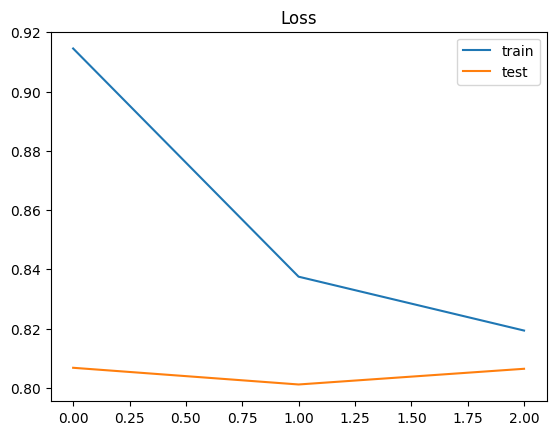

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

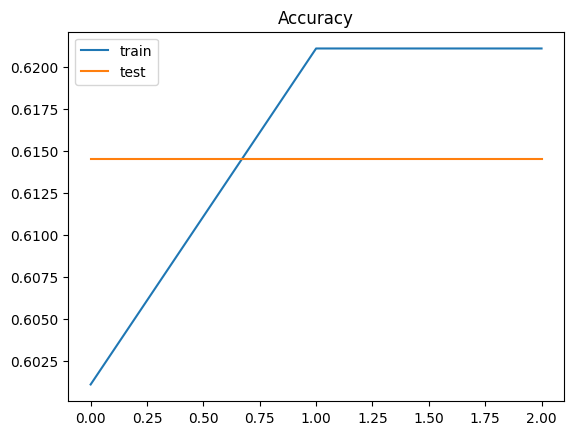

In [21]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# ==== MODEL PERFORMANCE WITH LOADED MODEL ====

# PREDICTION FUNCTION AND CLASSIFICATION REPORT

In [28]:
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
import numpy as np

# The maximum number of words to be used. (most frequent)
FREQUENT_WORDS_COUNT = 20000
# Max number of words for the padding -> max length tweet 280 chars ~60 words, also best results after experimenting
SEQUENCE_LENGTH_COUNT = 60

def prepare_tokenizer_new_input(frequent, train_data):
    tokenizer = Tokenizer(num_words=frequent, lower=True, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_data["Tweet"].values)
    return tokenizer

def get_results(dataframe, model, tokenizer, column_name='Tweet'):
    # Ensure the column exists in the dataframe
    if column_name not in dataframe.columns:
        raise ValueError(f"Column {column_name} not found in the dataframe.")

    # Convert tweets to sequences and pad them
    sequences = tokenizer.texts_to_sequences(dataframe[column_name].values)
    padded_sequences = pad_sequences(sequences, maxlen=SEQUENCE_LENGTH_COUNT)

    # Get model predictions
    predictions = model.predict(padded_sequences)

    # Map predictions to sentiment labels
    labels = ['negative', 'neutral', 'positive']
    predicted_labels = [labels[np.argmax(pred)] for pred in predictions]

    # Generate classification report
    return classification_report(dataframe['Sentiment'].values, predicted_labels)




In [29]:
from keras.models import load_model

# Load the model
loaded_model = load_model('PIDGIN_LSTM_OOV.h5')




In [30]:
# Example usage
tokenizer = prepare_tokenizer_new_input(FREQUENT_WORDS_COUNT, df)
report = get_results(dfi, loaded_model, tokenizer, column_name='Tweet')
print(report)

62/62 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

    negative       0.08      0.03      0.04       130
     neutral       0.63      0.14      0.23      1222
    positive       0.32      0.86      0.47       627

    accuracy                           0.36      1979
   macro avg       0.34      0.34      0.25      1979
weighted avg       0.50      0.36      0.29      1979



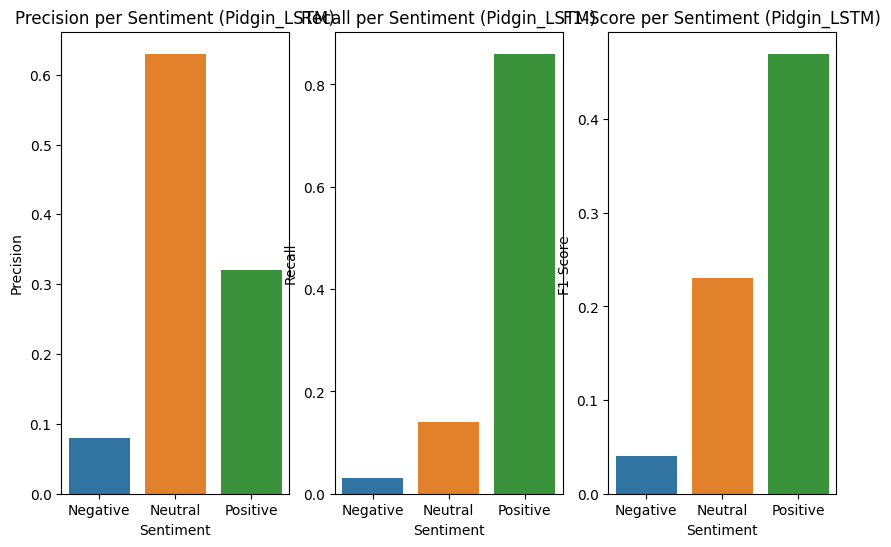

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for Pidgin LSTM model
data_pidgin = {
    "Sentiment": ["Negative", "Neutral", "Positive"],
    "Precision": [0.08, 0.63, 0.32],
    "Recall": [0.03, 0.14, 0.86],
    "F1-Score": [0.04, 0.23, 0.47],
    "Support": [130, 1222, 627]
}

df_pidgin = pd.DataFrame(data_pidgin)

# Plotting
plt.figure(figsize=(10, 6))

# Precision, Recall, and F1-Score for Pidgin_LSTM Model
plt.subplot(1, 3, 1)
sns.barplot(x="Sentiment", y="Precision", data=df_pidgin)
plt.title("Precision per Sentiment (Pidgin_LSTM)")

plt.subplot(1, 3, 2)
sns.barplot(x="Sentiment", y="Recall", data=df_pidgin)
plt.title("Recall per Sentiment (Pidgin_LSTM)")

plt.subplot(1, 3, 3)
sns.barplot(x="Sentiment", y="F1-Score", data=df_pidgin)
plt.title("F1-Score per Sentiment (Pidgin_LSTM)")

# Save the figure
plt.savefig('pidgin_lstm_performance.png', dpi=300)

# Show the plot
plt.show()
